In [2]:
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import os
from joblib import Parallel, delayed
import multiprocessing
from utils_abr import replace_abbreviations
from nltk.tokenize import word_tokenize
import spacy
# Install necessary libraries if not installed
# pip install gensim
# pip install nltk
# pip install joblib 
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import multiprocessing
from joblib import Parallel, delayed
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import multiprocessing
from joblib import Parallel, delayed

# Load French stopwords from NLTK
import nltk
nltk.download('stopwords')
stopwords_list = set(stopwords.words('french'))


[nltk_data] Downloading package punkt to /Users/oaouina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:


from gensim.models.callbacks import CallbackAny2Vec
# Load the French language model from spaCy
nlp = spacy.load('fr_core_news_sm')



directory="/Users/oaouina/Applications/pythonProject/Dataset/models/"


# Improved function to clean data
def clean_data(w):
    # Replace abbreviations before lowercasing
    w = replace_abbreviations(w)
    # Process the text using spaCy
    doc = nlp(w)
    
    # Extract tokens
    tokens = [token.text for token in doc]
    print(tokens)
    
    # Convert to lowercase
    w = w.lower()
    
   # Normalize different types of apostrophes to a single type
    w = re.sub(r"[’`]", "'", w)  # Normalize different apostrophe forms to a single one

    # Step 1: Remove all numbers first
    w = re.sub(r'\d+', '', w)

    # Step 2: Temporarily replace units with slashes with a placeholder to preserve them
    # This captures patterns like "mg/j", "g/l", etc.
    w = re.sub(r'([a-zA-Z]+/[a-zA-Z]+)', lambda m: m.group(0).replace('/', '_'), w)

    # Step 3: Remove punctuation but keep hyphenated words and apostrophes
    w = re.sub(r"[^\w\s'-]", '', w)  # Allows hyphens and apostrophes to remain

    # Step 4: Restore preserved units (replacing underscores back with slashes)
    w = re.sub(r'([a-zA-Z]+_[a-zA-Z]+)', lambda m: m.group(0).replace('_', '/'), w)

    # Step 5: Remove extra spaces created during the cleaning process
    w = re.sub(r'\s+', ' ', w).strip()  # Replace multiple spaces with a single space and strip leading/trailing spaces

    # Tokenize using NLTK word_tokenize for better handling of punctuation and contractions
    words = word_tokenize(w, language='french')

    # Remove stopwords and keep words with more than 2 characters
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]

    # Join words back into a single string
    return clean_words

# Improved function to clean data using spaCy
def clean_datav2(w):
    # Step 1: Replace abbreviations
    w = replace_abbreviations(w)

    # Step 2: Process the text using spaCy
    doc = nlp(w)

    # Step 3: Extract and clean tokens using spaCy features
    clean_tokens = []
    for token in doc:
        # Remove punctuation, numbers, and unwanted tokens (e.g., spaces)
        if token.is_punct or token.is_digit or token.is_space:
            continue

        # Convert to lowercase and normalize apostrophes
        normalized_token = token.text.lower().replace("’", "'").replace("`", "'")

        # Remove stopwords and keep words with more than 2 characters
        if normalized_token not in stopwords_list and len(normalized_token) > 2:
            clean_tokens.append(normalized_token)

    return clean_tokens

# Function to load and preprocess a single file
def preprocess_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            content = str(content)  # Ensure content is a standard string
            cleaned_content = clean_datav2(content)  # Clean the text
            return cleaned_content
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return []
        
# Function to load and preprocess French text data using multiprocessing
#def load_french_texts(directory_path):
#    files = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path) if filename.endswith(".txt")]
#    num_cores = multiprocessing.cpu_count()
#    print("Num cores ",num_cores)
#    documents = Parallel(n_jobs=num_cores-2)(delayed(preprocess_file)(file_path) for file_path in files)
#    return documents


# Function to load and preprocess French text data using multithreading
def load_french_texts(directory_path):
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} does not exist.")
        return []

    # List all text files in the directory
    files = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path) if filename.endswith(".txt")]

    # If no text files are found, print a warning and return
    if not files:
        print(f"Warning: No text files found in the directory {directory_path}.")
        return []

    # Use ThreadPoolExecutor for multithreading
    documents = []
    print("Processing documents with multithreading...")

    # Define the number of threads
    num_threads = min(8, len(files))  # Use 8 threads or less if there are fewer files

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Submit all the tasks to the executor
        future_to_file = {executor.submit(preprocess_file, file_path): file_path for file_path in files}

        # Collect results as they complete
        for future in as_completed(future_to_file):
            file_path = future_to_file[future]
            try:
                result = future.result()
                documents.append(result)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return documents


# Global list to store the loss at each epoch
loss_list = []

# Custom callback class for early stopping
class EarlyStoppingCallback(CallbackAny2Vec):
    def __init__(self, patience=10, min_delta=0.001):
        self.epoch = 0
        self.losses = []
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.wait = 0
        self.stop_training = False  # Initialize stop_training attribute

    def on_epoch_end(self, model):
        # Get the latest training loss
        current_loss = model.get_latest_training_loss()
        
        # Calculate loss for the current epoch
        if self.epoch == 0:
            loss = current_loss
        else:
            loss = current_loss - sum(self.losses)

        # Append the current loss to the global loss list
        loss_list.append(loss)
        
        # Print the current loss
        print(f'Loss after epoch {self.epoch}: {loss}')
        
        # Update internal losses list
        self.losses.append(loss)

        # Check for early stopping
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0  # Reset patience counter if loss improves
        else:
            self.wait += 1

        # Trigger early stopping if patience has been exceeded
        if self.wait >= self.patience:
            print(f"Early stopping triggered after {self.epoch + 1} epochs.")
            self.stop_training = True

        # Increment epoch counter
        self.epoch += 1



# Define the callback class
class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        # Get the latest training loss
        loss = model.get_latest_training_loss()
        loss_list.append(loss)
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        
        # Reset the running training loss after each epoch
        model.running_training_loss = 0.0
        self.epoch += 1
class LossCallback(CallbackAny2Vec):
    """Callback to track and print loss during training, with early stopping"""
    def __init__(self, patience=5):
        self.epoch = 0
        self.patience = patience
        self.best_loss = float('inf')
        self.no_improvement_count = 0
        self.loss_list = []

    def on_epoch_end(self, model):
        # Get the latest training loss
        current_loss = model.get_latest_training_loss()

        # Calculate epoch loss
        if self.epoch == 0:
            loss = current_loss
        else:
            loss = current_loss - self.previous_loss

        self.loss_list.append(loss)
        print(f'Loss after epoch {self.epoch}: {loss}')

        # Check for improvement for early stopping
        if loss < self.best_loss:
            self.best_loss = loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            print(f"No improvement for {self.no_improvement_count} epochs.")

        # Early stopping condition
        if self.no_improvement_count >= self.patience:
            print("Early stopping triggered.")
            raise StopIteration

        # Set previous loss for next epoch comparison
        self.previous_loss = current_loss



In [6]:
# Directory containing French text files
directory_path = "/Users/oaouina/Applications/brat_Annotator/data/AllData"

# Load and preprocess French texts using multiprocessing
french_documents = load_french_texts(directory_path)
# Get the total number of CPU cores
cores = multiprocessing.cpu_count()
print(f'Total number of CPU cores: {cores}')
# Train a Word2Vec model on the French texts



Processing documents with multithreading...
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/51674_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/44541_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/16505_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/32149_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/10481_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/13239001.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/47672_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Anno


KeyboardInterrupt



Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/60354_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/8415483.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/48687_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/33784_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/filepdf-216-cas.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/24316_a.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/14325699.txt: name 'stopwords_list' is not defined
Error processing file /Users/oaouina/Applications/brat_Annotator/data/AllData/31860_a.txt: name

In [90]:
len(french_documents)

11698

In [33]:
# Train a Word2Vec model with adjusted parameters
model = Word2Vec(
    sentences=french_documents,  # List of tokenized sentences
    vector_size=200,
    window=5,
    min_count=5,
    workers=8,
    sg=1,                # Skip-gram (sg=1)
   alpha=0.01,              # Decrease initial learning rate
    min_alpha=0.0005,        # Slightly higher minimum learning rate
    negative=10,         # Number of negative samples
    max_vocab_size=None # Max vocabulary size
)
# Build vocabulary
model.build_vocab(french_documents)


# Instantiate the callback
early_stopping_callback = EarlyStoppingCallback(patience=10, min_delta=0.001)

# Train the model with the callback
# The following code will stop if early stopping is triggered
for epoch in range(500):
    if early_stopping_callback.stop_training:
        break
    model.train(
        french_documents,
        total_examples=model.corpus_count,
        epochs=1,  # Train for a single epoch at a time
        compute_loss=True,
        callbacks=[early_stopping_callback]
    )
        
# Save the trained model
model.save("french_word2vec200sg.model")

# Example usage: find similar words
word = "schizophrénie"  # Replace with a French word you want to check
if word in model.wv:
    similar_words = model.wv.most_similar(word, topn=5)
    print(f"Top 5 words similar to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity:.2f}")
else:
    print(f"Word '{word}' not in vocabulary.")

Loss after epoch 0: 6851914.5
Loss after epoch 1: 557342.5
Loss after epoch 2: 108140.0
Loss after epoch 3: -359271.0
Loss after epoch 4: -865529.0
Loss after epoch 5: 1106739.0
Loss after epoch 6: -292721.0
Loss after epoch 7: -52292.0
Loss after epoch 8: 8883.0
Loss after epoch 9: 275033.0
Loss after epoch 10: -264337.0
Loss after epoch 11: -818763.0
Loss after epoch 12: 763119.5
Loss after epoch 13: 50569.5
Loss after epoch 14: -104872.5
Early stopping triggered after 15 epochs.
Top 5 words similar to 'schizophrénie':
indifférenciée: 0.80
paranoïde: 0.76
schizophrénique: 0.73
dysthymique: 0.71
schizophrène: 0.70


In [34]:
#french_documents

In [35]:
# Example usage: find similar words
word = "schizophrène"  # Replace with a French word you want to check
if word in model.wv:
    similar_words = model.wv.most_similar(word, topn=5)
    print(f"Top 5 words similar to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity:.2f}")
else:
    print(f"Word '{word}' not in vocabulary.")


Top 5 words similar to 'schizophrène':
schizophrénie: 0.70
schizophrènie: 0.68
hébéphrène: 0.65
souffrant: 0.64
65ans: 0.63


In [36]:
# Example usage: find similar words
word = "addictologie"  # Replace with a French word you want to check
if word in model.wv:
    similar_words = model.wv.most_similar(word, topn=5)
    print(f"Top 5 words similar to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity:.2f}")
else:
    print(f"Word '{word}' not in vocabulary.")

Top 5 words similar to 'addictologie':
addictologue: 0.68
moreau: 0.68
montecristo: 0.67
addictologique: 0.65
capitan: 0.64


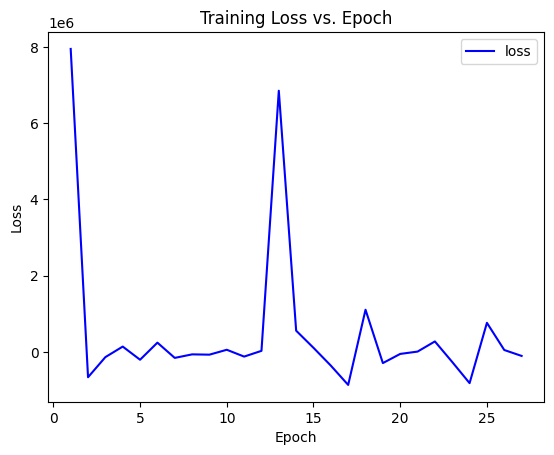

In [37]:
import matplotlib.pyplot as plt

# Create a range for epochs
epochs = list(range(1, len(loss_list) + 1))

# Plot the loss vs epoch graph
plt.plot(epochs, loss_list, color='blue', label='loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Show the plot
plt.show()

In [38]:
import spacy
# Improved function to clean data with proper handling of contractions
def tokezine_data(w):
    
    # Replace abbreviations before lowercasing
    w = replace_abbreviations(w)
    
    # Convert to lowercase
    w = w.lower()
    
    # Normalize different types of apostrophes to a single type
    w = re.sub(r"[’`]", "'", w)  # Normalize different apostrophe forms to a single one

    # Step 1: Remove all numbers first
    w = re.sub(r'\d+', '', w)

    # Step 2: Properly split contractions like "l'humeur"
    w = re.sub(r"\b([cdjlmnst])'([a-z]+)", r"\1' \2", w)

    # Step 3: Remove punctuation but keep hyphenated words and apostrophes
    w = re.sub(r"[^\w\s'-]", '', w)  # Allows hyphens and apostrophes to remain

    # Step 4: Remove extra spaces created during the cleaning process
    w = re.sub(r'\s+', ' ', w).strip()  # Replace multiple spaces with a single space and strip leading/trailing spaces

    # Tokenize using NLTK word_tokenize for better handling of punctuation and contractions
    words = word_tokenize(w, language='french')

    # Remove stopwords and keep words with more than 2 characters
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return clean_words


# Text to tokenize
sample_text = "c'est l'humeur du patient est stable. Il n'a pas d'idée noire qu'elle est belle."



# Example usage
words = word_tokenize(sample_text, language='french')
cleaned_text = tokezine_data(sample_text)
print(cleaned_text)

['humeur', 'patient', 'stable', 'idée', 'noire', "qu'elle", 'belle']


In [44]:
from gensim.models import KeyedVectors

# Load the pre-trained Word2Vec model (binary format)
psycho_w2v_model = model.wv

# Check some information about the model
print("Number of words in vocabulary:", len(psycho_w2v_model))
print("Embedding dimension:", psycho_w2v_model.vector_size)

Number of words in vocabulary: 29004
Embedding dimension: 200


In [39]:
#!python -m spacy download fr_core_news_sm

In [40]:
word1 = "schizophrénie"
word2 = "symptôme"

if word1 in model.wv and word2 in model.wv:
    similarity = model.wv.similarity(word1, word2)
    print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.2f}")
else:
    print(f"One of the words '{word1}' or '{word2}' not in vocabulary.")

Cosine similarity between 'schizophrénie' and 'symptôme': 0.27


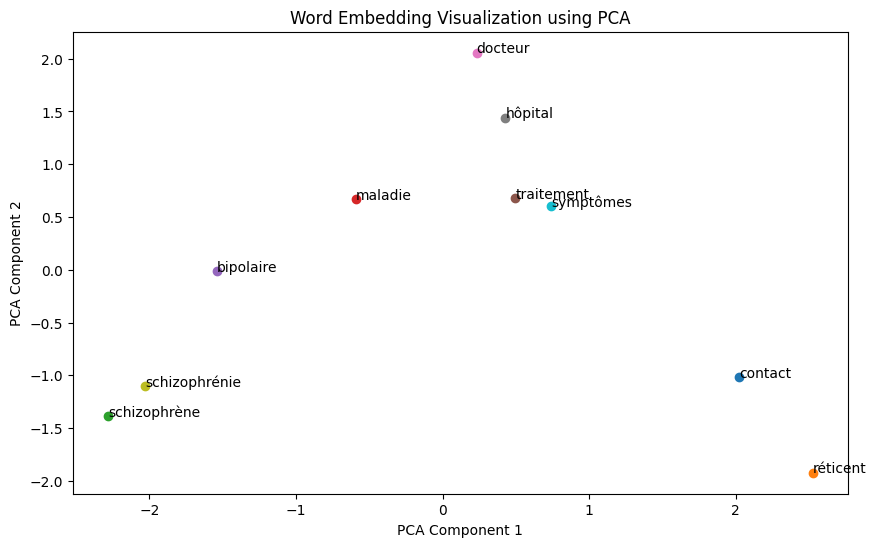

In [89]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Choose a few words from the vocabulary to visualize
words = ['contact', 'réticent',"schizophrène","maladie","bipolaire", 'traitement', 'docteur', 'hôpital', 'schizophrénie', 'symptômes']
word_vectors = [model.wv[word] for word in words if word in model.wv]

# Reduce the dimensionality of the embeddings to 2D using PCA
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vectors)

# Plot the words
plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    if word in model.wv:
        plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
        plt.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]))

plt.title("Word Embedding Visualization using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


# FineTune a model Jean-Philippe Fauconnier word2vec on my documents

In [71]:
from gensim.models import KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

        self.epoch += 1

# Load the pre-trained Word2Vec model (binary format)
file_path = '/Users/oaouina/Applications/pythonProject/Dataset/models/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin'
pretrained_w2v_model = KeyedVectors.load_word2vec_format(file_path, binary=True)

# Check some information about the model
print("Number of words in vocabulary:", len(pretrained_w2v_model))
print("Embedding dimension:", pretrained_w2v_model.vector_size)

Number of words in vocabulary: 155562
Embedding dimension: 200


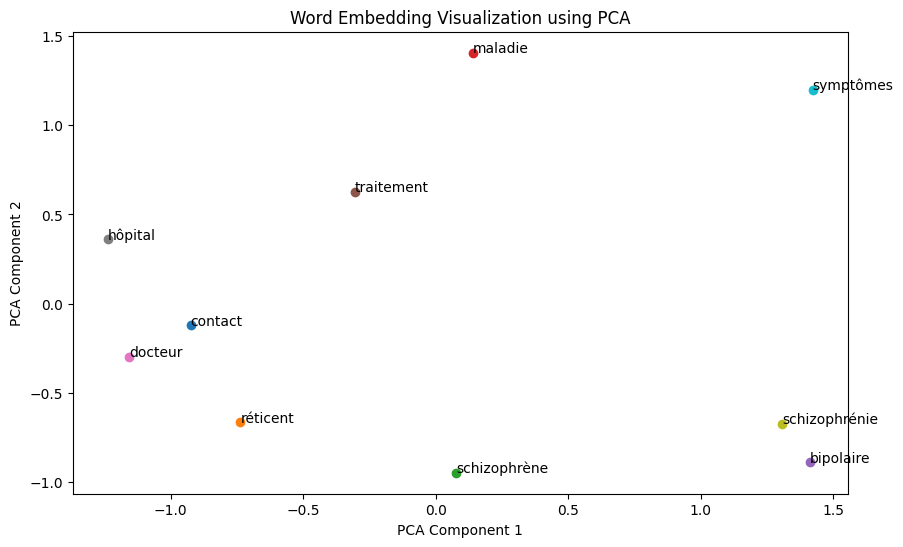

In [88]:
# Choose a few words from the vocabulary to visualize
words = ['contact', 'réticent',"schizophrène","maladie","bipolaire", 'traitement', 'docteur', 'hôpital', 'schizophrénie', 'symptômes']
word_vectors = [pretrained_w2v_model[word] for word in words if word in pretrained_w2v_model]

# Reduce the dimensionality of the embeddings to 2D using PCA
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vectors)

# Plot the words
plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    if word in model.wv:
        plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
        plt.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]))

plt.title("Word Embedding Visualization using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [79]:
from collections import Counter

# Flatten the tokenized sentences to count word frequencies
all_words = [word for sentence in french_documents for word in sentence]

# Count word frequencies
word_freq = Counter(all_words)

# Filter words that are frequent enough and domain-specific
min_frequency = 10
filtered_vocab = [word for word, freq in word_freq.items() if freq >= min_frequency]

# Recreate domain-specific documents with only words from the filtered vocabulary
filtered_documents = [[word for word in sentence if word in filtered_vocab] for sentence in french_documents]

# Update the model with the filtered vocabulary
word2vec_model.build_vocab(french_documents, update=True)



In [80]:
# Fine-tune with filtered documents
# Create a new Word2Vec model with pre-trained vectors
word2vec_model = Word2Vec(vector_size=pretrained_w2v_model.vector_size, window=5, min_count=1, sg=1)
word2vec_model.build_vocab([list(pretrained_w2v_model.key_to_index.keys())], update=False)
word2vec_model.wv.vectors[:] = pretrained_w2v_model.vectors

# Build the vocabulary with the filtered medical documents
word2vec_model.build_vocab(filtered_documents, update=True)

# Create an instance of the LossCallback
loss_callback = LossCallback(patience=5)

# Fine-tune the model with the callback and use try-except for early stopping
try:
    word2vec_model.train(
        filtered_documents,
        total_examples=len(filtered_documents),
        epochs=50,               # Number of epochs for fine-tuning
        start_alpha=0.005,       # Lower starting learning rate
        end_alpha=0.0005,        # Gradually reduce learning rate
        compute_loss=True,       # Enable loss computation to use in callback
        callbacks=[loss_callback]
    )
except StopIteration:
    print("Training stopped early due to early stopping.")



# Save the fine-tuned model
word2vec_model.save("fine_tuned_word2vec_medical_subset_cutoff100.model")
word2vec_model.wv.save_word2vec_format(directory+'fine_tuned_word2vec_medical_subset_cutoff100.word2vec', binary=False)

Loss after epoch 0: 17688558.0
Loss after epoch 1: 10523662.0
Loss after epoch 2: 8034620.0
Loss after epoch 3: 5714888.0
Loss after epoch 4: 5353296.0
Loss after epoch 5: 5556956.0
No improvement for 1 epochs.
Loss after epoch 6: 5569640.0
No improvement for 2 epochs.
Loss after epoch 7: 5514428.0
No improvement for 3 epochs.
Loss after epoch 8: 3409408.0
Loss after epoch 9: 592880.0
Loss after epoch 10: 588784.0
Loss after epoch 11: 561400.0
Loss after epoch 12: 582520.0
No improvement for 1 epochs.
Loss after epoch 13: 579872.0
No improvement for 2 epochs.
Loss after epoch 14: 582296.0
No improvement for 3 epochs.
Loss after epoch 15: 587720.0
No improvement for 4 epochs.
Loss after epoch 16: 579880.0
No improvement for 5 epochs.
Early stopping triggered.
Training stopped early due to early stopping.


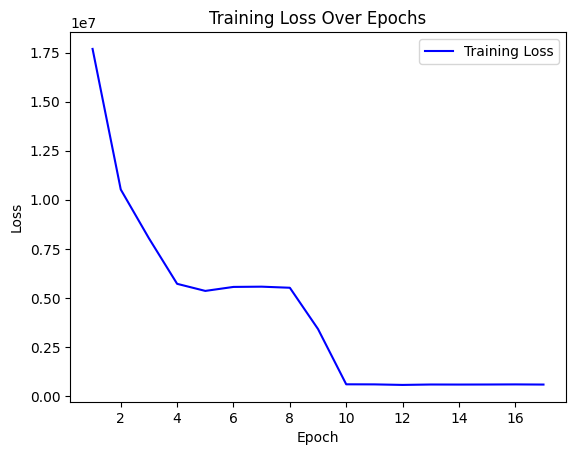

In [81]:


# Save the fine-tuned model
#word2vec_model.save("fine_tuned_word2vec_medical.model")
import matplotlib.pyplot as plt

# Plotting the training loss
epochs = list(range(1, len(loss_callback.loss_list) + 1))
plt.plot(epochs, loss_callback.loss_list, color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [82]:
print("Most similar words to 'symptôme':", word2vec_model.wv.most_similar('symptôme', topn=5))


Most similar words to 'symptôme': [('élément', 0.7710264921188354), ('évident', 0.7415980100631714), ('franc', 0.732065737247467), ('idée', 0.7115220427513123), ('instinctuel', 0.7094569802284241)]


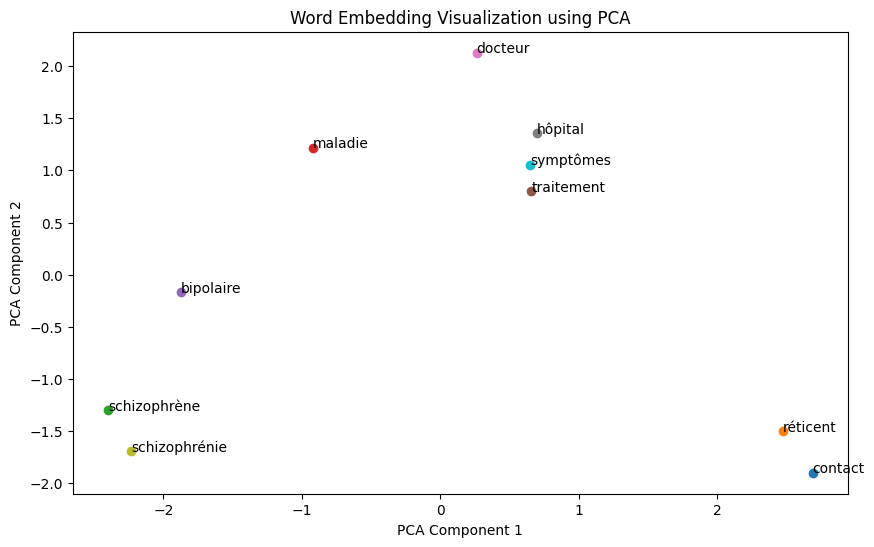

In [87]:
# Choose a few words from the vocabulary to visualize
words = ['contact', 'réticent',"schizophrène","maladie","bipolaire", 'traitement', 'docteur', 'hôpital', 'schizophrénie', 'symptômes']
word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]

# Reduce the dimensionality of the embeddings to 2D using PCA
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vectors)

# Plot the words
plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    if word in model.wv:
        plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
        plt.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]))

plt.title("Word Embedding Visualization using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [1]:
import gensim
print(gensim.__version__)

4.3.2


In [3]:
from gensim.models import Word2Vec
directory="/Users/oaouina/Applications/pythonProject/Dataset/models/"
pre_train_model ="/Users/oaouina/Applications/pythonProject/Dataset/models/fine_tuned_word2vec_medical_subset_cutoff100.model"

word2vec_model = Word2Vec.load(pre_train_model)
# Save the model in .word2vec format
# Save in word2vec text format
word2vec_model.wv.save_word2vec_format(directory+'fine_tuned_word2vec_medical_subset_cutoff100.word2vec', binary=False)


In [7]:
word2vec_model =  Word2Vec.load(directory+'fine_tuned_word2vec_medical_subset_cutoff100.model')


In [8]:
word2vec_model =  Word2Vec.load('/Users/oaouina/Applications/pythonProject/RelationExtraction/fine_tuned_word2vec_medical_subset_cutoff100.model')


In [9]:
import gensim
import numpy

print("Gensim version:", gensim.__version__)
print("Numpy version:", numpy.__version__)

Gensim version: 4.3.2
Numpy version: 1.26.4
